In [6]:
#%matplotlib inline 
import obspy
from obspy.io.segy.core import _read_segy
import numpy as np
import matplotlib.pyplot as plt

"""Install jupyter nb extensions to get red dashed line at 80 characters

    Trying to be make code look neat

    Not sticking to this religously yet

""" 


'Install jupyter nb extensions to get red dashed line at 80 characters\n\n    Trying to be make code look neat\n\n    Not sticking to this religously yet\n\n'

## load segy data

data loaded into 2D array, headers into separate 1D arrays, see obspy docs

see github.com/obspy/obspy/blob/master/obspy/io/segy/header.py#L53

In [7]:
def readsegy(inputfile, file_headers,DF_ASL, SrcElev, SRD_ASL):
    
    """ Load a segy file using obspy read_segy routine
        Number of traces can come from binary header or trace headers or
        the shape of the data file
        
        nrcv = section.stats.binary_file_header.number_of_data_traces_per_ens.
        can be useful if filled
        
        We use the matrix shape in this example to figure out the number of 
        traces and the number of samples per trace
        
        inputfile - segy file
        file_headers  - optionally print binary headers to terminal
        DF_ASL - drill floor elevation above Sea Level
        SrcElev - source elevation above sea level
        SRD_ASL - seismic reference datum above sea level
        
        Some useful headers are filled for velocity calculation
    """
    
    from obspy.io.segy.segy import _read_segy
    
    section = _read_segy(inputfile, unpack_headers = 'True')
    
    if (file_headers == 'y') or (file_headers == 'Y'):
    
        print (section.binary_file_header)
    
        x = np.array(list(section.textual_file_header.decode()))
        
        print('\n'.join(''.join(row) for row in x.reshape((40, 80))))
            
    data = np.vstack([d.data for d in section.traces])
    
    nrcv, samples = data.shape
  
    trnum, nsamp, srate, zscale, zrcv, tsr, mdpth, tvddpth, scalcoord, xsrc,\
    ysrc, sdpth, xrcv, yrcv, auxtime_ms, ttime,ttime_ms = (np.empty(nrcv),\
          np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),\
          np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),\
          np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),np.empty(nrcv),\
          np.empty(nrcv), np.empty(nrcv),np.empty(nrcv), np.empty(nrcv) )
        
    n=0
    
    #get basic info from trace headers
    
    for tr in section.traces:
    
        trnum[n] = tr.header.trace_sequence_number_within_line
        nsamp[n] = tr.header.number_of_samples_in_this_trace
        srate[n] = tr.header.sample_interval_in_ms_for_this_trace
        zscale[n] = tr.header.scalar_to_be_applied_to_all_elevations_and_depths
        mdpth[n] = tr.header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group
        tvddpth[n] = tr.header.receiver_group_elevation
        scalcoord[n] = tr.header.scalar_to_be_applied_to_all_coordinates
        xsrc[n] = tr.header.source_coordinate_x/abs(scalcoord[n])
        ysrc[n] = tr.header.source_coordinate_y/abs(scalcoord[n])
        sdpth[n] = tr.header.source_depth_below_surface
        xrcv[n] = tr.header.group_coordinate_x/abs(scalcoord[n])
        yrcv[n] = tr.header.group_coordinate_y/abs(scalcoord[n])
        auxtime_ms[n]  = tr.header.lag_time_A          #trunc. to nearest ms
        ttime_ms[n]  = tr.header.lag_time_B            # trunc.to nearest ms
        ttime[n]  = tr.header.shotpoint_number/100     # divide if used
        
        n=n+1
    
    mdpth = mdpth/abs(zscale)
    
    tvddpth = tvddpth/abs(zscale)
    
    SrcZ = (sdpth *0) + SrcElev # careful, comment out if field is correct

    TVD_Src = tvddpth - (DF_ASL - SrcElev)
        
    TVD_SRD = tvddpth - (DF_ASL - SRD_ASL)
    
    SrcZ_SRD = SrcZ-SRD_ASL
    
    ############## make a file of trace headers #############################
    
    thead = np.vstack([trnum, mdpth, tvddpth,xrcv, yrcv,  xsrc, ysrc, sdpth, 
                       ttime,TVD_SRD, TVD_Src, SrcZ_SRD,auxtime_ms])
    
    ############## sort out sample rates ####################################
    
    numsamp = nsamp[0]
    samprate = srate[0]                    # sample interval in microseconds
    samprate_hz = 1000000/samprate
        
    tindex = np.zeros(shape = (data.shape[0], int(numsamp*(samprate/1000))))
    
    for k in range(0,data.shape[0]):
        tindex[k,:] = np.arange(0, numsamp*(samprate/1000) )  # samprate in ms
        
    ########### print some QC data to screen ################################

    print("\u0332".join('\nData Loading Stats :'))
    
    print (' data shape :', data.shape)
    
    print (' trace header file shape :', thead.T.shape)
    
    print (' samples :', data.shape[1],' traces :', data.shape[0], ' ttime: ',\
           ttime.shape, ' fs samprate hz : ', samprate_hz, \
           'samprate microseconds : ', samprate, \
           '\n numsamp from headers : ', numsamp)
    
    print (' first time header value : ',ttime[0:1], \
           '\n first auxilliary time header value :', auxtime_ms[0:1])
    
    print (' source depth from header trace 1 :', sdpth[0:1])
    
    return data, numsamp, samprate, samprate_hz, tindex, thead.T

# Quick image style, gray scale plot

In [11]:
def quick_plot(VSP1, title1, scale):
    
    plt.figure(figsize=(15,10))
    
    ax1 = plt.subplot(111)

    ax1.imshow(VSP1.T, cmap="gray", interpolation='none', 
               vmin = -abs(VSP1).max()/scale,
               vmax = abs(VSP1).max()/scale,
               aspect = 'auto')
        
    ax1.yaxis.grid()
    
    ax1.set_xlabel('trace')
    
    ax1.set_ylabel('sample number')
    
    ax1.set_title(title1)
    
    textstr =  'Data max : %s'%(VSP1.max())
    
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
             verticalalignment='top')
    
    plt.show()

## Main module


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape : (6400, 3000)
 trace header file shape : (6400, 13)
 samples : 3000  traces : 6400  ttime:  (6400,)  fs samprate hz :  1000.0 samprate microseconds :  1000.0 
 numsamp from headers :  3000.0
 first time header value :  [844.29] 
 first auxilliary time header value : [0.]
 source depth from header trace 1 : [100.]


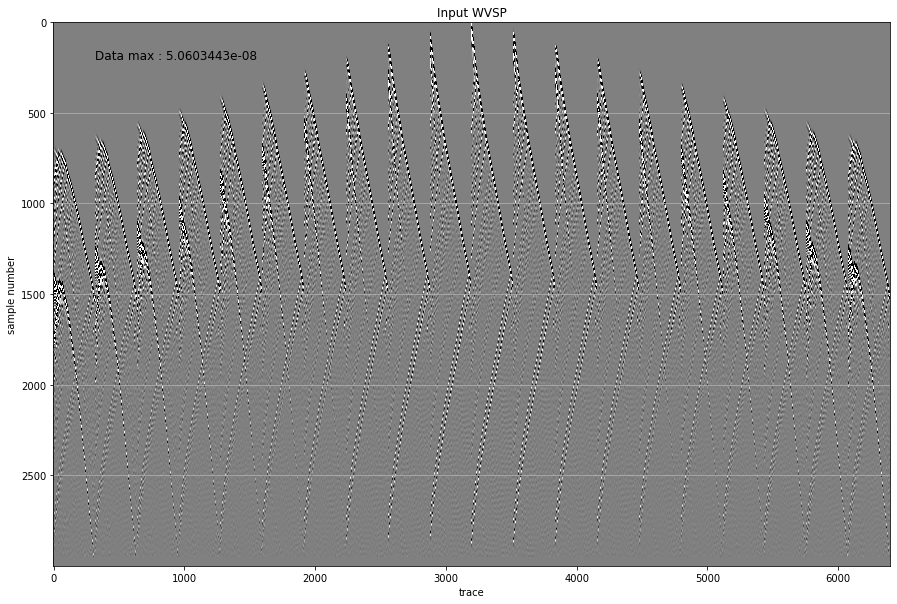

In [14]:
def main ():
   
    ############ get the data #########
    
    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
        '\\Synthetic_data\\data\\wvsp_z_fd_mod5_12p5ft_grid_delayed.sgy')
    
    ############ input desired geometry parameters #########
    
    RepVel= 5000     # replacement velocity
    SRD_ASL = 0    # SRD elevation above sea level
    DF_ASL = 0    # drill floor elevation ASL
    SrcElev = -10   # source elevation ASL


    ############ run basic loading functions ######### 
    
    file_head = 'n'         # print binary and text header to screen
    
    data, numsamp, samprate, fs, tindex,theader =  readsegy(
                      filename, file_head, DF_ASL, SrcElev, SRD_ASL)
    
    
    header1 = 'Input WVSP'
    
    scalar = 200
    
    quick_plot(data, header1, scalar)      # simple gray scale plot
    

    

main()